In [1]:
import torch
import re
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from transformers import Qwen2_5_VLForConditionalGeneration, AutoProcessor
from qwen_vl_utils import process_vision_info
import os


/users/eleves-a/2025/youssef.sidhom/Object_detection_in_documents/venv/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

# --- CONFIGURATION ---
# Replace this with the path to an image you want to test
IMAGE_PATH = "data/qwen_signatures_ready/images/test_0.jpg" 
MODEL_PATH = "Qwen/Qwen2.5-VL-7B-Instruct"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# --- HELPER FUNCTIONS ---
def extract_boxes(text, w, h):
    """Parses <box>(y1,x1),(y2,x2)</box> output to pixels [x1, y1, x2, y2]"""
    # Regex for coordinates
    pattern = r"\((\d+),(\d+)\),\((\d+),(\d+)\)"
    matches = re.findall(pattern, text)
    
    boxes = []
    for m in matches:
        # Qwen output is (y1, x1, y2, x2) on 0-1000 scale
        y1, x1, y2, x2 = map(int, m)
        
        # Convert to absolute pixels
        boxes.append([
            (x1 / 1000.0) * w,  # x_min
            (y1 / 1000.0) * h,  # y_min
            (x2 / 1000.0) * w,  # x_max
            (y2 / 1000.0) * h   # y_max
        ])
    return boxes

def show_result(image, boxes, raw_output):
    """Displays the image with bounding boxes inline"""
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    ax = plt.gca()
    
    for box in boxes:
        # Create a Red Rectangle (Prediction)
        rect = patches.Rectangle(
            (box[0], box[1]), 
            box[2] - box[0], 
            box[3] - box[1], 
            linewidth=3, 
            edgecolor='red', 
            facecolor='none', 
            linestyle='--',
            label='Prediction'
        )
        ax.add_patch(rect)

    plt.title(f"Model Output: {raw_output}", fontsize=12)
    plt.axis('off')
    plt.legend()
    plt.show()


In [3]:

# --- MAIN EXECUTION ---
print(f">> Loading Model: {MODEL_PATH}...")

# 1. Load Processor
processor = AutoProcessor.from_pretrained(MODEL_PATH, min_pixels=256*28*28, max_pixels=1280*28*28)

# 2. Load Model (bfloat16 for memory efficiency)
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    MODEL_PATH,
    torch_dtype=torch.bfloat16,
    attn_implementation="sdpa",
    device_map="auto"
)
model.eval()


>> Loading Model: Qwen/Qwen2.5-VL-7B-Instruct...


The image processor of type `Qwen2VLImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. Note that this behavior will be extended to all models in a future release.
`torch_dtype` is deprecated! Use `dtype` instead!
Loading checkpoint shards: 100%|██████████| 5/5 [00:01<00:00,  3.45it/s]


Qwen2_5_VLForConditionalGeneration(
  (model): Qwen2_5_VLModel(
    (visual): Qwen2_5_VisionTransformerPretrainedModel(
      (patch_embed): Qwen2_5_VisionPatchEmbed(
        (proj): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
      )
      (rotary_pos_emb): Qwen2_5_VisionRotaryEmbedding()
      (blocks): ModuleList(
        (0-31): 32 x Qwen2_5_VLVisionBlock(
          (norm1): Qwen2RMSNorm((1280,), eps=1e-06)
          (norm2): Qwen2RMSNorm((1280,), eps=1e-06)
          (attn): Qwen2_5_VLVisionAttention(
            (qkv): Linear(in_features=1280, out_features=3840, bias=True)
            (proj): Linear(in_features=1280, out_features=1280, bias=True)
          )
          (mlp): Qwen2_5_VLMLP(
            (gate_proj): Linear(in_features=1280, out_features=3420, bias=True)
            (up_proj): Linear(in_features=1280, out_features=3420, bias=True)
            (down_proj): Linear(in_features=3420, out_features=1280, bias=True)
            (act_fn): SiLUAc

In [7]:

# 3. Load & Process Image
if not os.path.exists(IMAGE_PATH):
    print(f"Error: Image not found at {IMAGE_PATH}")
else:
    print(f">> Processing Image: {IMAGE_PATH}")
    image = Image.open(IMAGE_PATH).convert("RGB")
    w, h = image.size

    # 4. Create Prompt
    messages = [
        {
            "role": "user",
            "content": [
                {"type": "image", "image": image},
                {"type": "text", "text": "Locate the signature in this document."},
            ],
        }
    ]

    # 5. Prepare Inputs
    text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    image_inputs, video_inputs = process_vision_info(messages)
    
    inputs = processor(
        text=[text],
        images=image_inputs,
        videos=video_inputs,
        padding=True,
        return_tensors="pt",
    ).to(DEVICE)

    # 6. Generate
    print(">> Generating prediction...")
    with torch.no_grad():
        generated_ids = model.generate(**inputs, max_new_tokens=128)
        
    # 7. Decode
    generated_ids_trimmed = [
        out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
    ]
    output_text = processor.batch_decode(
        generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )[0]
    
    # 8. Visualize
    pred_boxes = extract_boxes(output_text, w, h)
    


>> Processing Image: data/qwen_signatures_ready/images/test_0.jpg
>> Generating prediction...


In [8]:
output_text

'The signature on the document is located at the bottom right corner, written in cursive and signed by "O. Stuhl."'

No signature detected. Raw Output: The signature on the document is located at the bottom right corner, written in cursive and signed by "O. Stuhl."


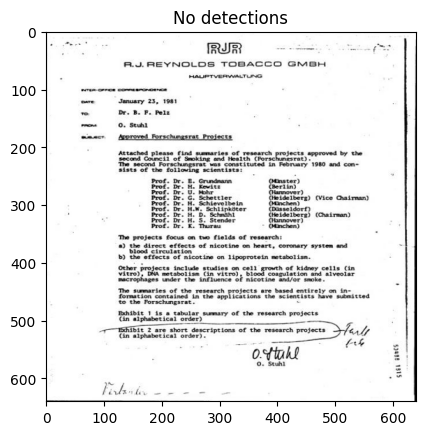

In [9]:
    if not pred_boxes:
        print(f"No signature detected. Raw Output: {output_text}")
        plt.imshow(image)
        plt.title("No detections")
        plt.show()
    else:
        print(f"Found {len(pred_boxes)} signature(s).")
        show_result(image, pred_boxes, output_text)